In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

In [114]:
plt.style.use('ggplot')

In [115]:
ticker = yf.Ticker('AAPL')
START = datetime.datetime(2015, 1, 1)
END = datetime.datetime(2023, 12, 31) 
df = ticker.history(start=START, end=END)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-01-02 00:00:00-05:00,24.895676,24.906852,23.992736,24.435266,212818400,0.0,0.0
2015-01-05 00:00:00-05:00,24.202828,24.283288,23.559148,23.746887,257142000,0.0,0.0
2015-01-06 00:00:00-05:00,23.811699,24.010613,23.384813,23.749119,263188400,0.0,0.0
2015-01-07 00:00:00-05:00,23.959210,24.182711,23.847460,24.082136,160423600,0.0,0.0
2015-01-08 00:00:00-05:00,24.412918,25.065538,24.294461,25.007427,237458000,0.0,0.0


<Axes: title={'center': 'Apple Stock Price'}, xlabel='Date'>

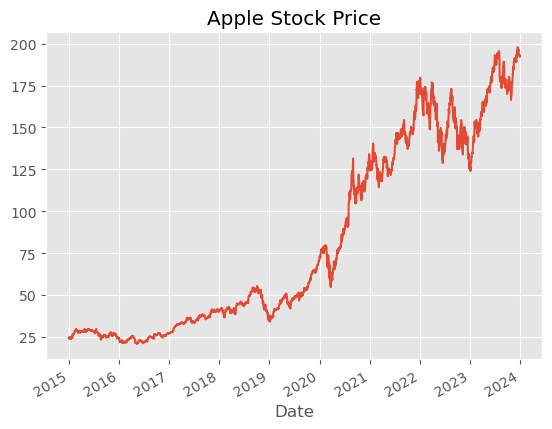

In [116]:
df['Close'].plot(title='Apple Stock Price')

In [117]:
df = df.reset_index()
print(f'Dimemsion of dataframe: {df.shape}') 
df.head()

Dimemsion of dataframe: (2264, 8)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-01-02 00:00:00-05:00,24.895676,24.906852,23.992736,24.435266,212818400,0.0,0.0
1,2015-01-05 00:00:00-05:00,24.202828,24.283288,23.559148,23.746887,257142000,0.0,0.0
2,2015-01-06 00:00:00-05:00,23.811699,24.010613,23.384813,23.749119,263188400,0.0,0.0
3,2015-01-07 00:00:00-05:00,23.959210,24.182711,23.847460,24.082136,160423600,0.0,0.0
4,2015-01-08 00:00:00-05:00,24.412918,25.065538,24.294461,25.007427,237458000,0.0,0.0


In [118]:
df = df.drop(['Dividends', 'Stock Splits', 'Date'], axis=1)
df

,Open,High,Low,Close,Volume
0,24.895676,24.906852,23.992736,24.435266,212818400
1,24.202828,24.283288,23.559148,23.746887,257142000
2,23.811699,24.010613,23.384813,23.749119,263188400
3,23.959210,24.182711,23.847460,24.082136,160423600
4,24.412918,25.065538,24.294461,25.007427,237458000
...,...,...,...,...,...
2259,194.931260,195.160978,192.724085,193.353287,37122800
2260,193.363270,193.642911,192.584265,192.803986,28919300
2261,192.244692,193.253399,190.846467,192.903839,48087700
2262,193.892582,194.411923,192.923817,193.333298,34049900


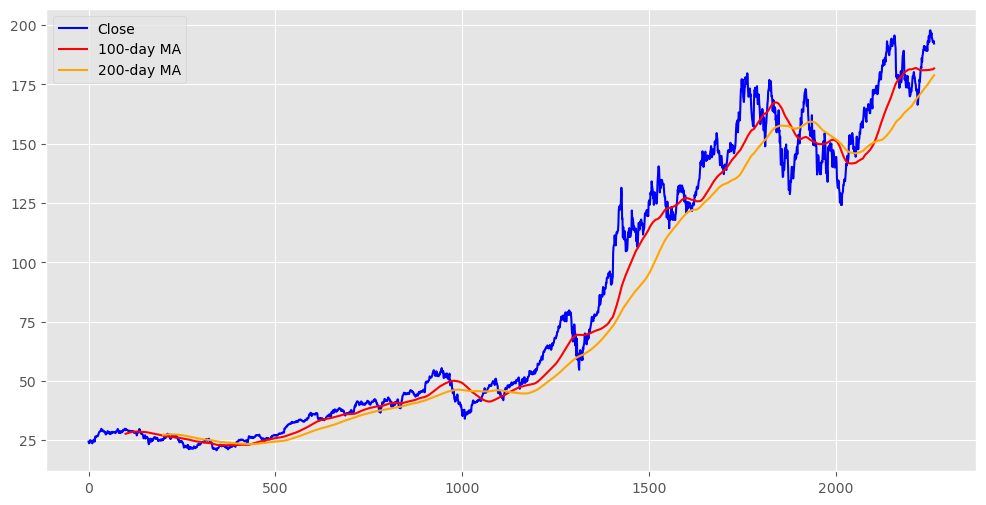

In [119]:
# MA stand for Moving Average helping smooth out 
# the data by creating a constantly updated average price
ma100 = df.Close.rolling(100).mean()
ma200 = df.Close.rolling(200).mean()

plt.figure(figsize=(12,6))
plt.plot(df.Close, 'b')
plt.plot(ma100, 'r')
plt.plot(ma200, 'orange')
plt.legend(['Close', '100-day MA', '200-day MA'])

In [120]:
training = df.Close[:int(len(df)*0.70)]
testing = df.Close[int(len(df)*0.70):]
print(f'Dimemsion of training data: {training.shape}')  
print(f'Dimemsion of testing data: {testing.shape}')    

Dimemsion of training data: (1584,)
Dimemsion of testing data: (680,)


In [121]:
scaler = MinMaxScaler(feature_range=(0,1))
training = scaler.fit_transform(np.array(training).reshape(-1, 1))
testing = scaler.fit_transform(np.array(testing).reshape(-1, 1))

In [122]:
x_train = []
y_train = []
x_test = []
y_test = []

for i in range(100, training.shape[0]):
    x_train.append(training[i-100:i])
    y_train.append(training[i])
for i in range(100, testing.shape[0]):
    x_test.append(testing[i-100:i])
    y_test.append(testing[i])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)

In [123]:
y_train

array([[0.07450826],
       [0.07168538],
       [0.07217463],
       ...,
       [0.93066028],
       [0.92786914],
       [0.93345156]])

In [124]:
model = Sequential()
# First 
model.add(LSTM(units = 50, activation = 'relu', 
               return_sequences = True, 
               input_shape = (x_train.shape[1], 1)))  
model.add(Dropout(0.2)) 

# Second
model.add(LSTM(units=60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

# Third
model.add(LSTM(units=80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))

# Fourth
model.add(LSTM(units=120, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))

model.summary() 

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 100, 50)           10400     
                                                                 
 dropout_28 (Dropout)        (None, 100, 50)           0         
                                                                 
 lstm_29 (LSTM)              (None, 100, 60)           26640     
                                                                 
 dropout_29 (Dropout)        (None, 100, 60)           0         
                                                                 
 lstm_30 (LSTM)              (None, 100, 80)           45120     
                                                                 
 dropout_30 (Dropout)        (None, 100, 80)           0         
                                                                 
 lstm_31 (LSTM)              (None, 120)              

In [125]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=3, verbose=1)

In [126]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=50, 
          validation_data=(x_test, y_test),
          callbacks=[early_stopping])

Epoch 1/50
47/47 [==============================] - 14s 193ms/step - loss: 0.0325 - val_loss: 0.0478
Epoch 2/50
47/47 [==============================] - 8s 178ms/step - loss: 0.0068 - val_loss: 0.0180
Epoch 3/50
47/47 [==============================] - 8s 178ms/step - loss: 0.0056 - val_loss: 0.0144
Epoch 4/50
47/47 [==============================] - 9s 184ms/step - loss: 0.0054 - val_loss: 0.0222
Epoch 5/50
47/47 [==============================] - 8s 179ms/step - loss: 0.0048 - val_loss: 0.0133
Epoch 6/50
47/47 [==============================] - 8s 179ms/step - loss: 0.0037 - val_loss: 0.0129
Epoch 7/50
47/47 [==============================] - 8s 178ms/step - loss: 0.0038 - val_loss: 0.0127
Epoch 8/50
47/47 [==============================] - 8s 179ms/step - loss: 0.0039 - val_loss: 0.0134
Epoch 9/50
47/47 [==============================] - 8s 180ms/step - loss: 0.0032 - val_loss: 0.0126
Epoch 10/50
47/47 [==============================] - 8s 179ms/step - loss: 0.0035 - val_loss: 0.012

In [127]:
y_pred = model.predict(x=x_test)
scale_factor = 1 / scaler.scale_
y_pred = y_pred * scale_factor
y_test = y_test * scale_factor


19/19 [==============================] - 1s 46ms/step


In [130]:
print(scaler.scale_)

[0.01298923]


Text(0.5, 1.0, 'Comparing actual and prediction values')

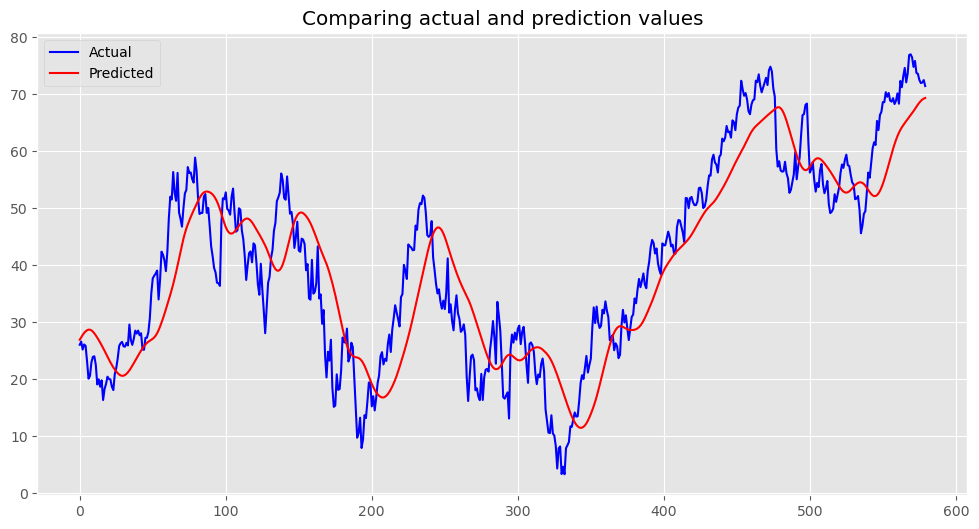

In [128]:
plt.figure(figsize=(12,6))
plt.plot(y_test, 'b')
plt.plot(y_pred, 'r')
plt.legend(['Actual', 'Predicted'])
plt.title('Comparing actual and prediction values')

In [129]:
model.save('lstm_model.h5')

c:\Users\qhuy9\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
